In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]
PyTorch version 2.6.0+cu118
Torchvision version 0.21.0+cu118
Numpy version 2.1.1
Pandas version 2.2.3


In [7]:
class FireDetection(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

In [8]:
dataset = FireDetection(
    data_dir='Datasets/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/train'
)

In [9]:
len(dataset)

32398

0


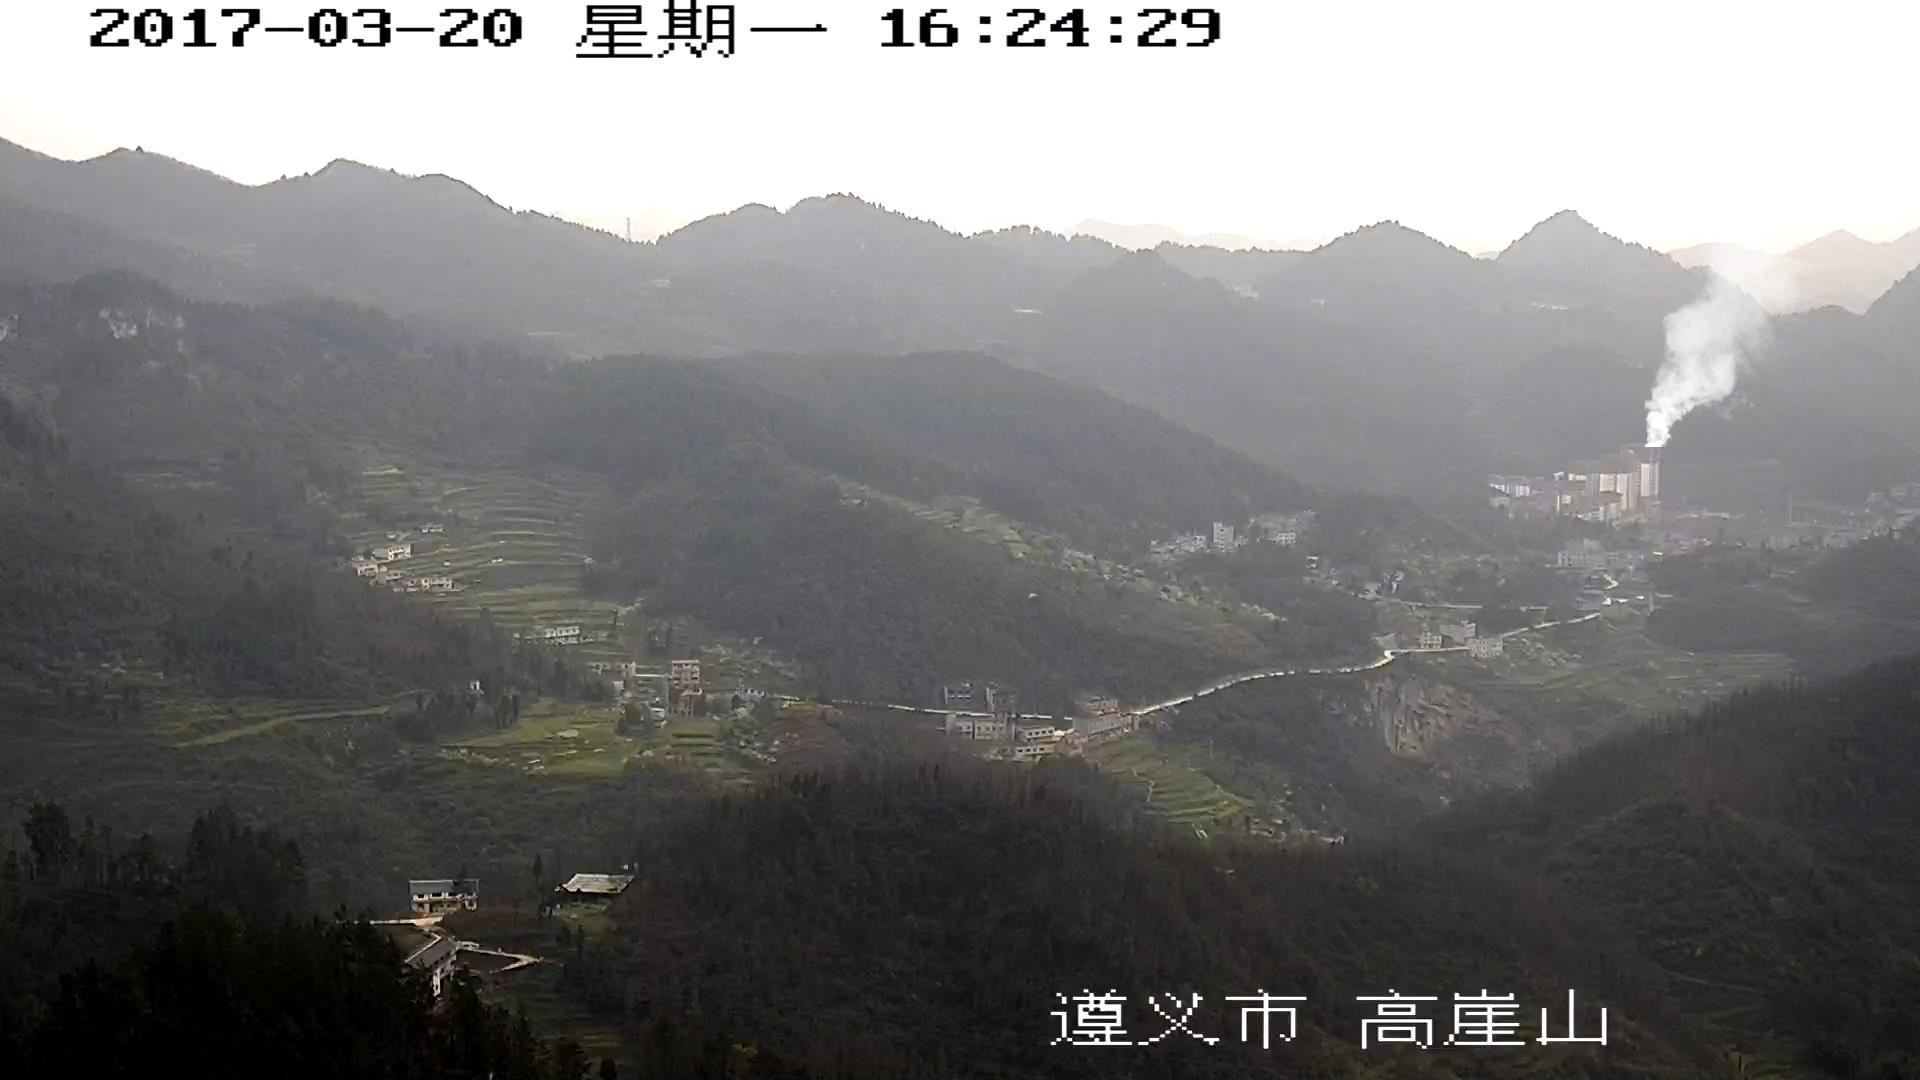

In [10]:
image, label = dataset[6000]
print(label)
image

In [11]:
data_dir='Datasets/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'Smoke', 1: 'fire', 2: 'non fire'}


In [12]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

data_dir='Datasets/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/train'
dataset = FireDetection(data_dir, transform)

In [13]:
image, label = dataset[100]
image.shape

torch.Size([3, 128, 128])

In [14]:
for image, label in dataset:
    break

In [15]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [16]:
for images, labels in dataloader:
    break

In [17]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [18]:
labels


tensor([0, 1, 1, 2, 0, 0, 2, 2, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 2, 2, 1,
        2, 0, 1, 2, 0, 1, 1, 2])

In [19]:
class SimpleFireClassifer(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleFireClassifer, self).__init__()
        # Where we define all the parts of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )
    
    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output

In [20]:
model = SimpleFireClassifer(num_classes=53)
print(str(model)[:500])

SimpleFireClassifer(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fal


In [21]:
example_out = model(images)
example_out.shape

torch.Size([32, 53])

In [22]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
criterion(example_out, labels)
print(example_out.shape, labels.shape)

torch.Size([32, 53]) torch.Size([32])


In [24]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = 'Datasets/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/train'
valid_folder = 'Datasets/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/valid'
test_folder = 'Datasets/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test'

train_dataset = FireDetection(train_folder, transform=transform)
val_dataset = FireDetection(valid_folder, transform=transform)
test_dataset = FireDetection(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define early stopping criteria
patience = 3  # Stop training if validation loss doesn't improve for `patience` epochs
best_val_loss = float('inf')
counter = 0  # Track epochs without improvement

num_epochs = 25
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleFireClassifer(num_classes=3)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct / total * 100  # Convert to percentage

    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0  # Reset counter if validation loss improves
        torch.save(model.state_dict(), "best_model.pth")  # Save best model
    else:
        counter += 1
        print(f"Early Stopping Counter: {counter}/{patience}")
        if counter >= patience:
            print("Early stopping triggered. Stopping training.")
            break  # Stop training


Validation loop: 100%|██████████| 165/165 [01:54<00:00,  1.44it/s]


Epoch 1/25 - Train loss: 0.1159, Validation loss: 0.0566, Validation Accuracy: 98.34%


Validation loop: 100%|██████████| 165/165 [01:44<00:00,  1.58it/s]


Epoch 2/25 - Train loss: 0.0652, Validation loss: 0.0511, Validation Accuracy: 98.70%


Validation loop: 100%|██████████| 165/165 [01:42<00:00,  1.60it/s]


Epoch 3/25 - Train loss: 0.0569, Validation loss: 0.0473, Validation Accuracy: 98.78%


Validation loop: 100%|██████████| 165/165 [01:48<00:00,  1.52it/s]


Epoch 4/25 - Train loss: 0.0457, Validation loss: 0.0451, Validation Accuracy: 98.55%


Validation loop: 100%|██████████| 165/165 [01:44<00:00,  1.57it/s]


Epoch 5/25 - Train loss: 0.0421, Validation loss: 0.0373, Validation Accuracy: 98.93%


Validation loop: 100%|██████████| 165/165 [01:47<00:00,  1.53it/s]


Epoch 6/25 - Train loss: 0.0370, Validation loss: 0.0396, Validation Accuracy: 98.91%
Early Stopping Counter: 1/3


Validation loop: 100%|██████████| 165/165 [01:43<00:00,  1.60it/s]


Epoch 7/25 - Train loss: 0.0397, Validation loss: 0.0709, Validation Accuracy: 98.00%
Early Stopping Counter: 2/3


Validation loop: 100%|██████████| 165/165 [01:43<00:00,  1.59it/s]


Epoch 8/25 - Train loss: 0.0303, Validation loss: 0.0257, Validation Accuracy: 99.18%


Validation loop: 100%|██████████| 165/165 [01:50<00:00,  1.49it/s]


Epoch 9/25 - Train loss: 0.0312, Validation loss: 0.0293, Validation Accuracy: 99.20%
Early Stopping Counter: 1/3


Validation loop: 100%|██████████| 165/165 [01:48<00:00,  1.52it/s]


Epoch 10/25 - Train loss: 0.0287, Validation loss: 0.0321, Validation Accuracy: 99.07%
Early Stopping Counter: 2/3


Validation loop: 100%|██████████| 165/165 [02:39<00:00,  1.04it/s]

Epoch 11/25 - Train loss: 0.0251, Validation loss: 0.0622, Validation Accuracy: 98.32%
Early Stopping Counter: 3/3
Early stopping triggered. Stopping training.


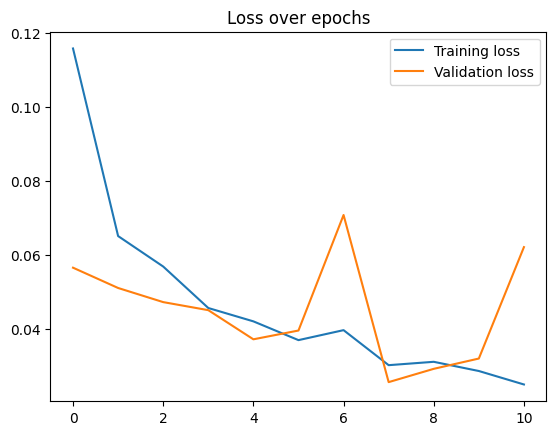

In [26]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

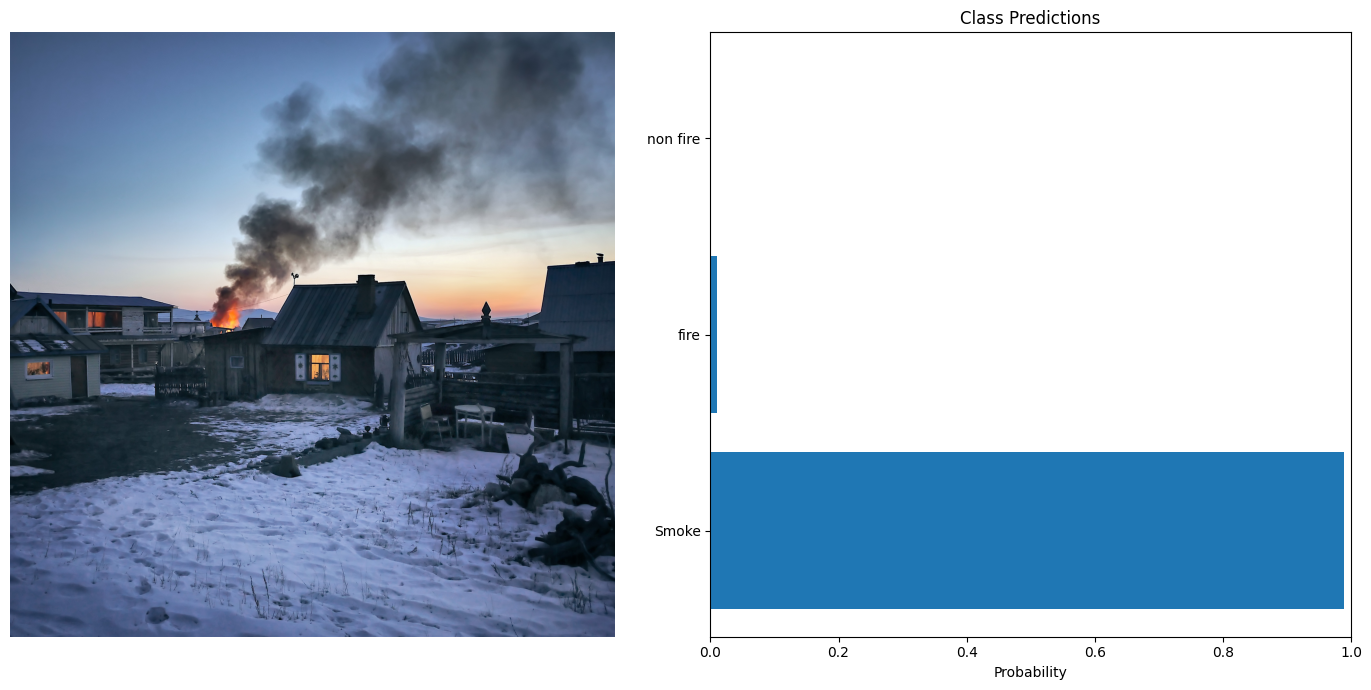

In [27]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "Datasets/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test/Smoke/Smoke (1).jpeg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes 
visualize_predictions(original_image, probabilities, class_names)

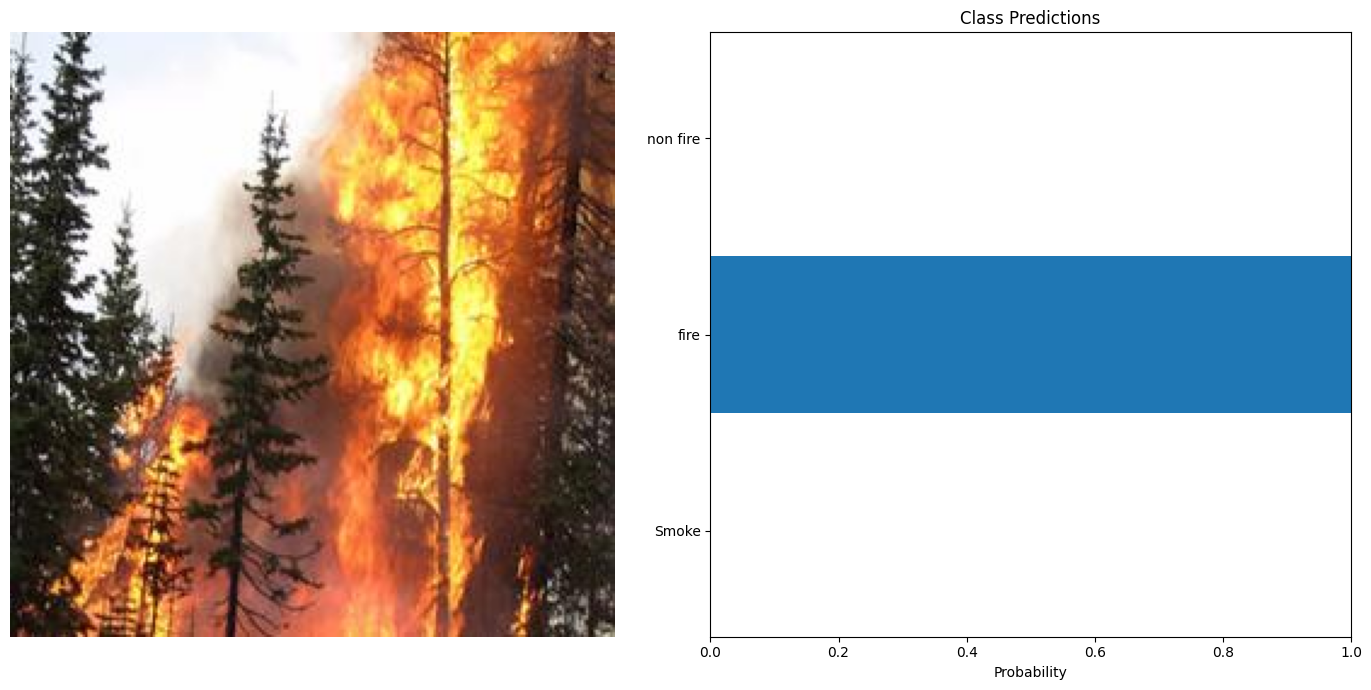

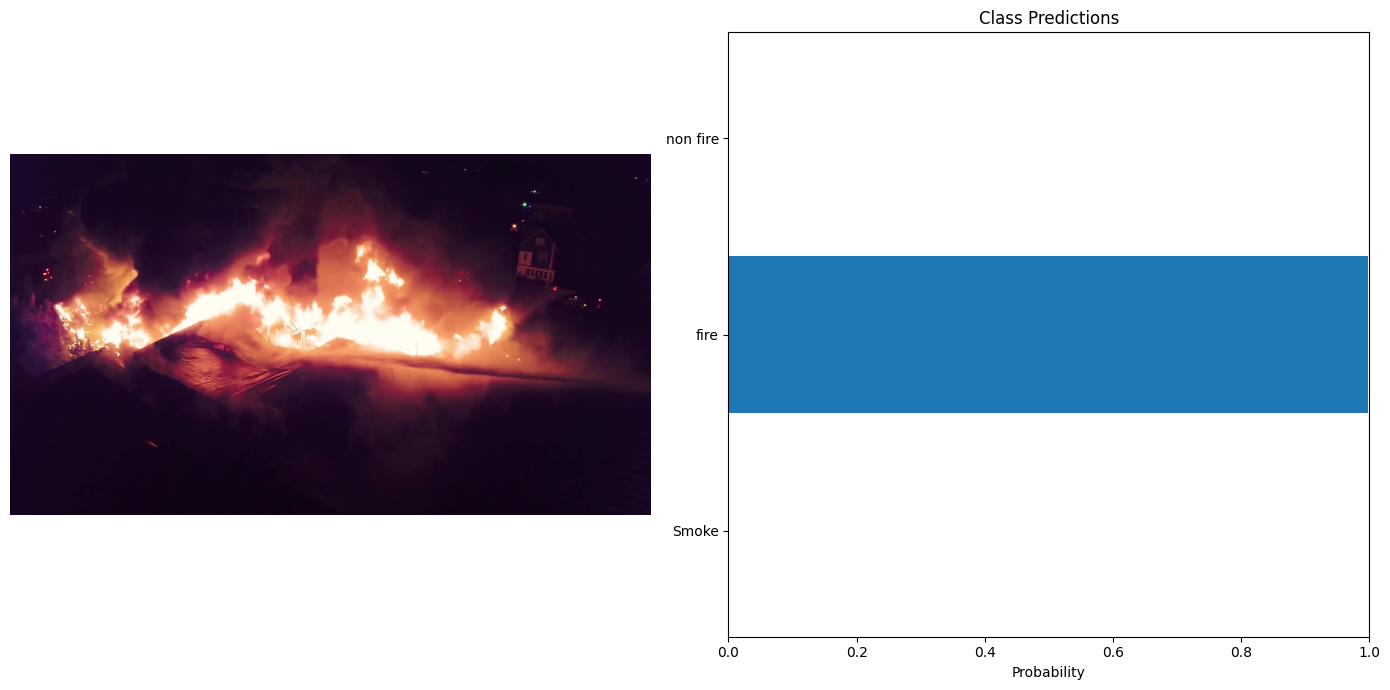

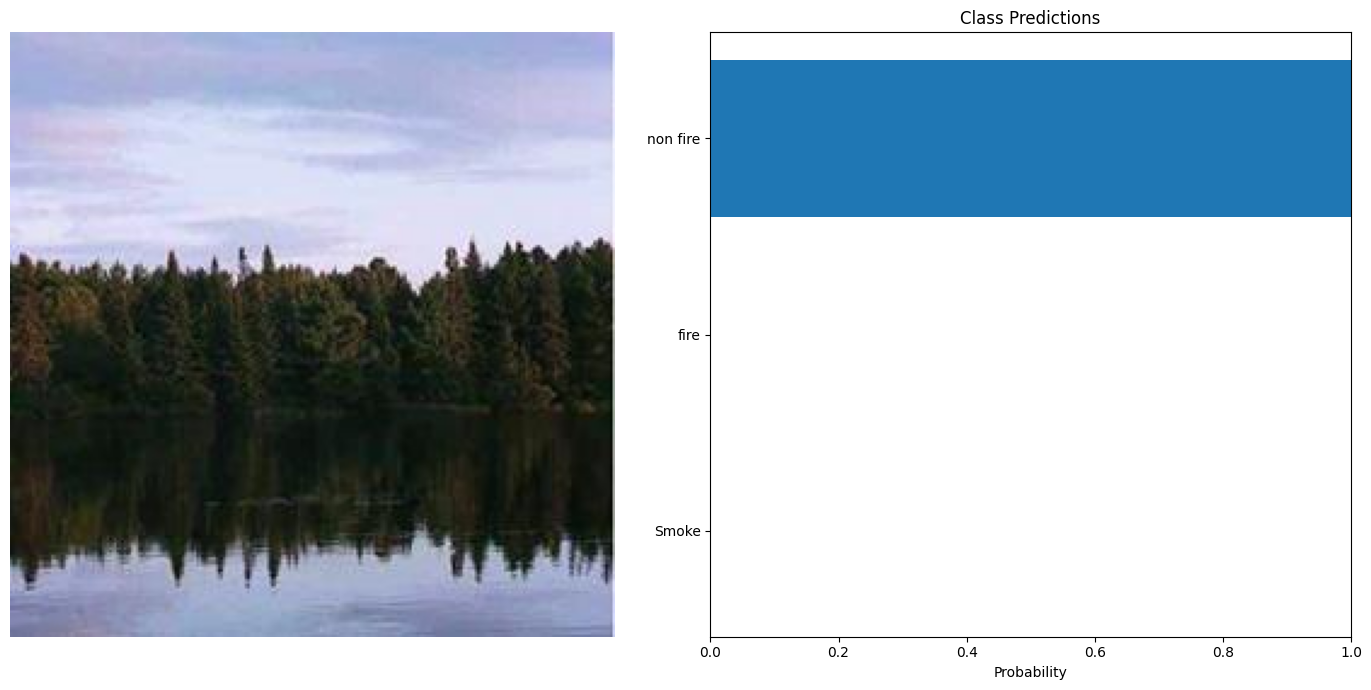

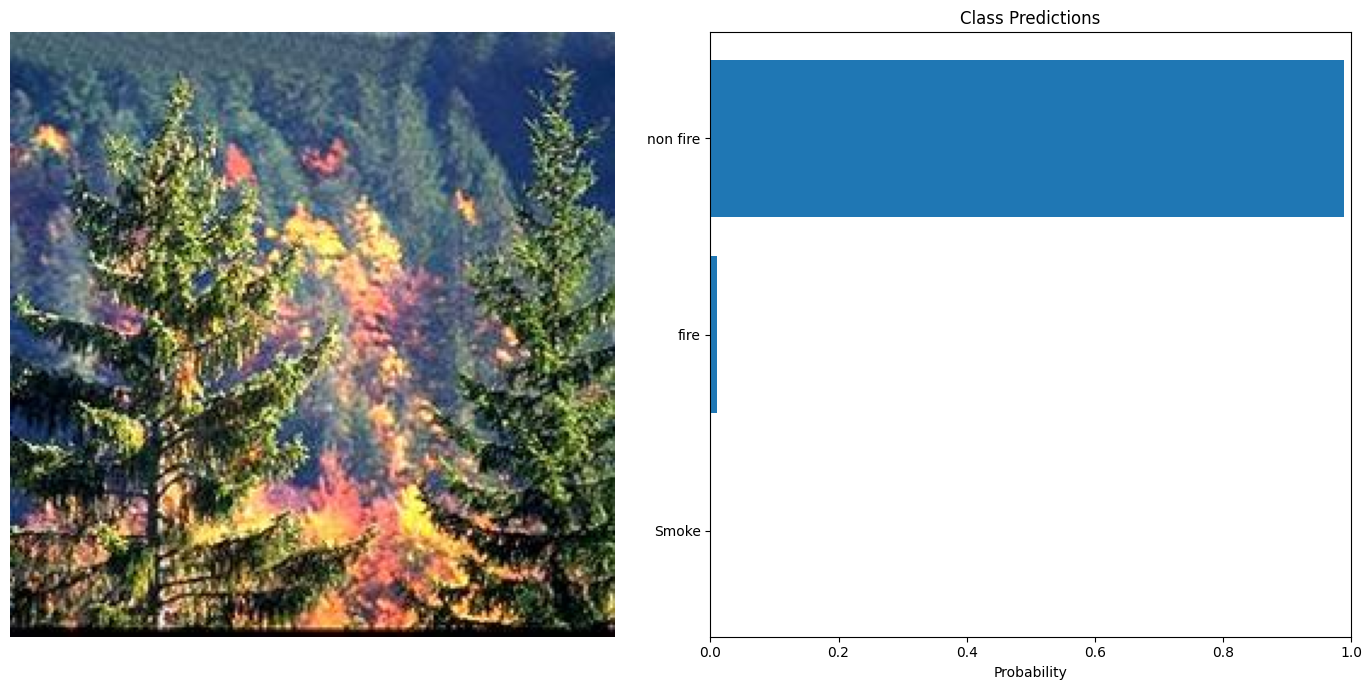

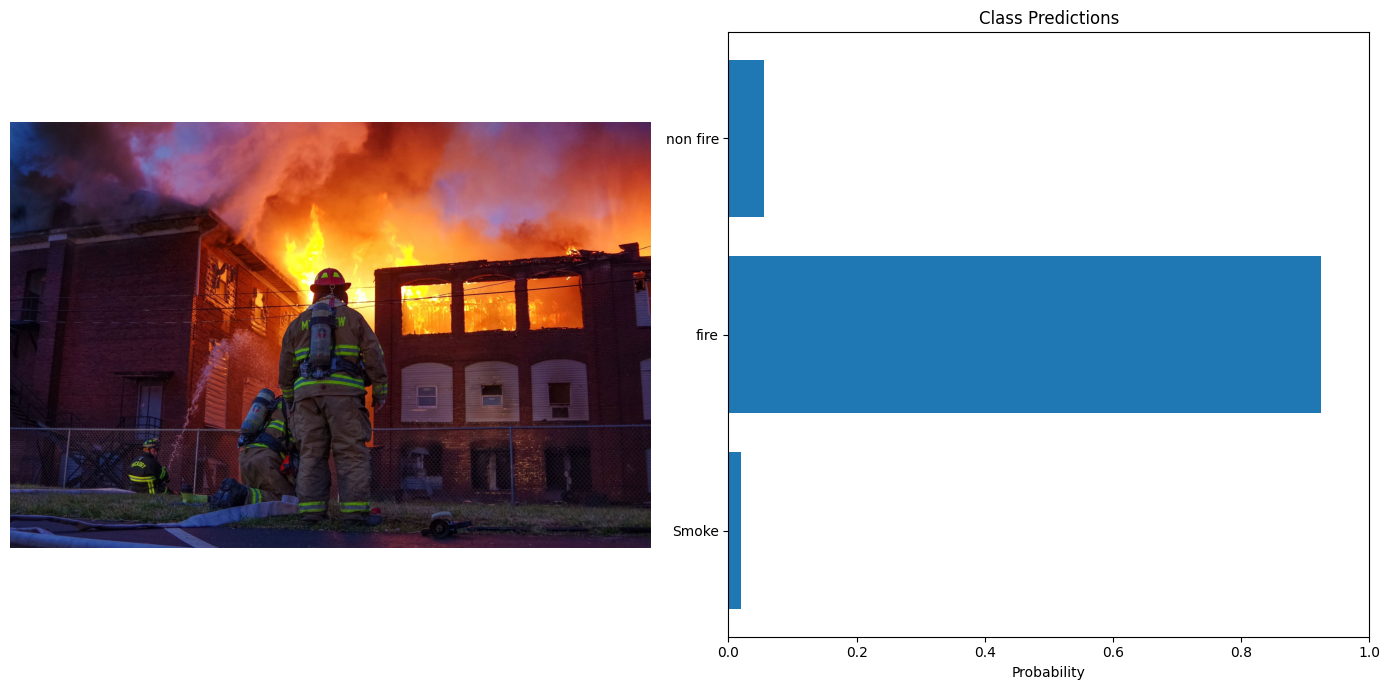

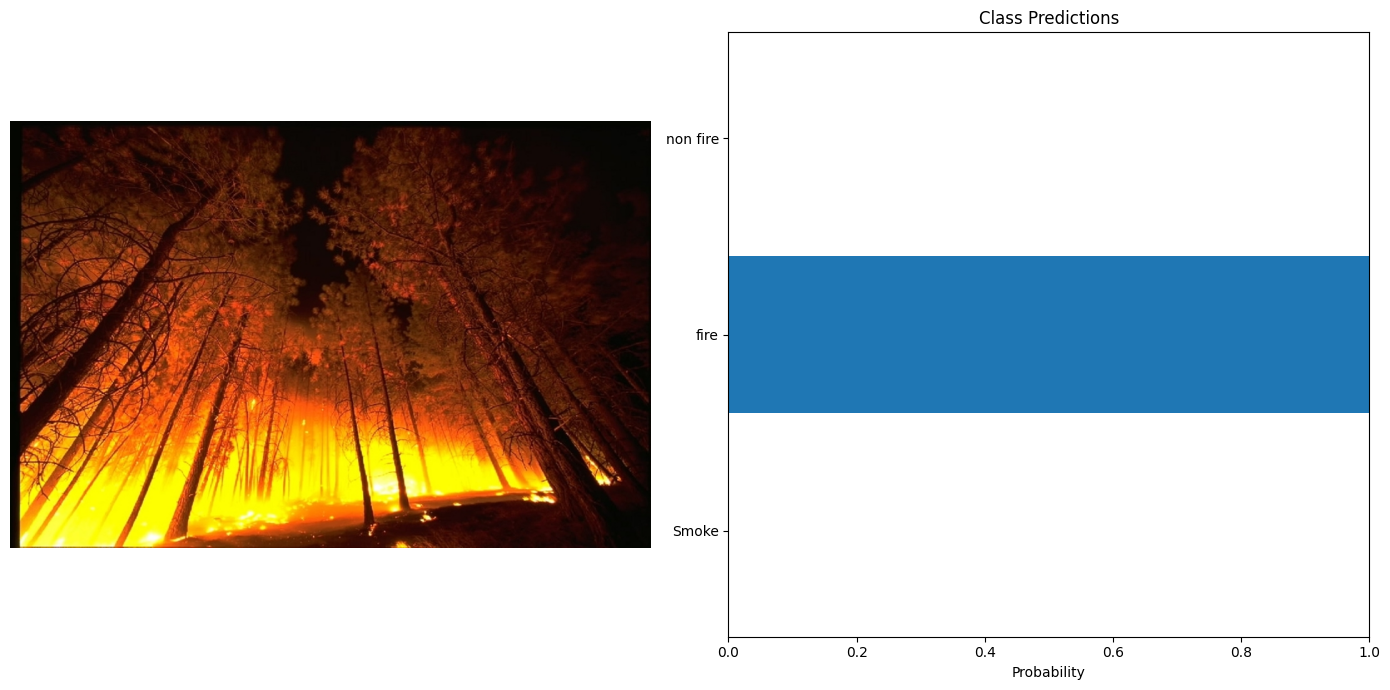

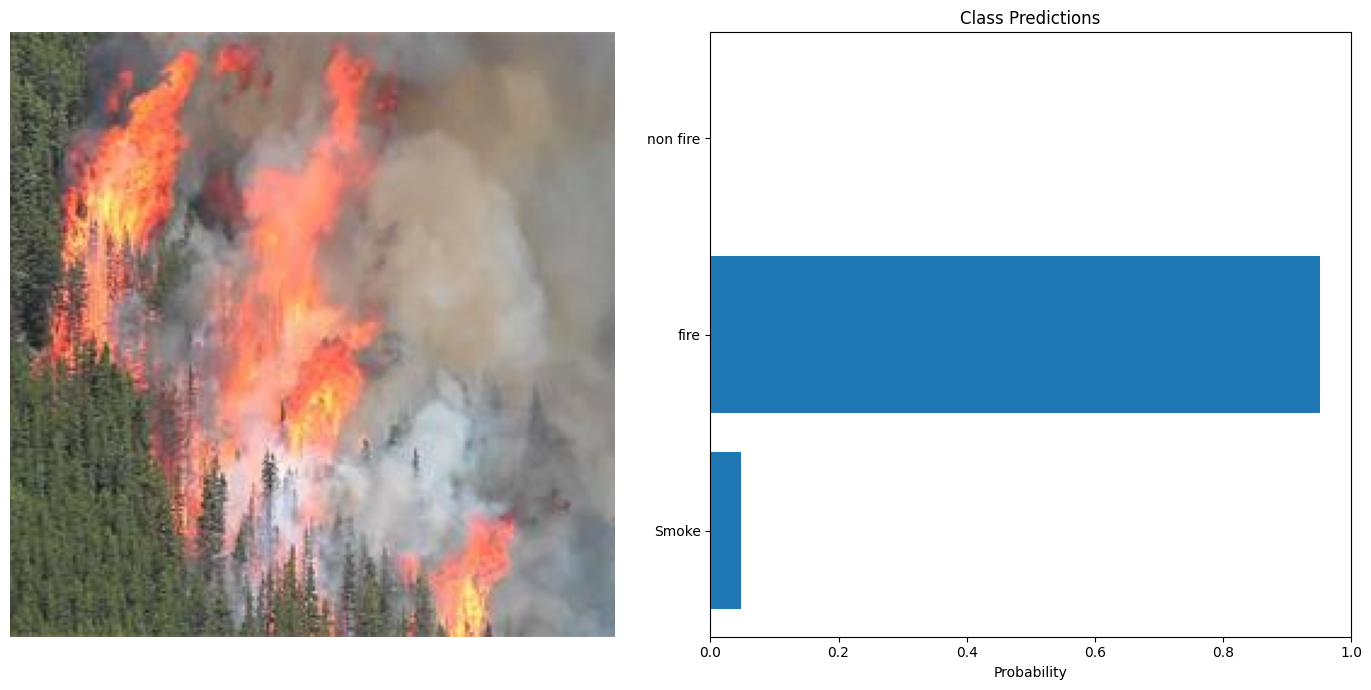

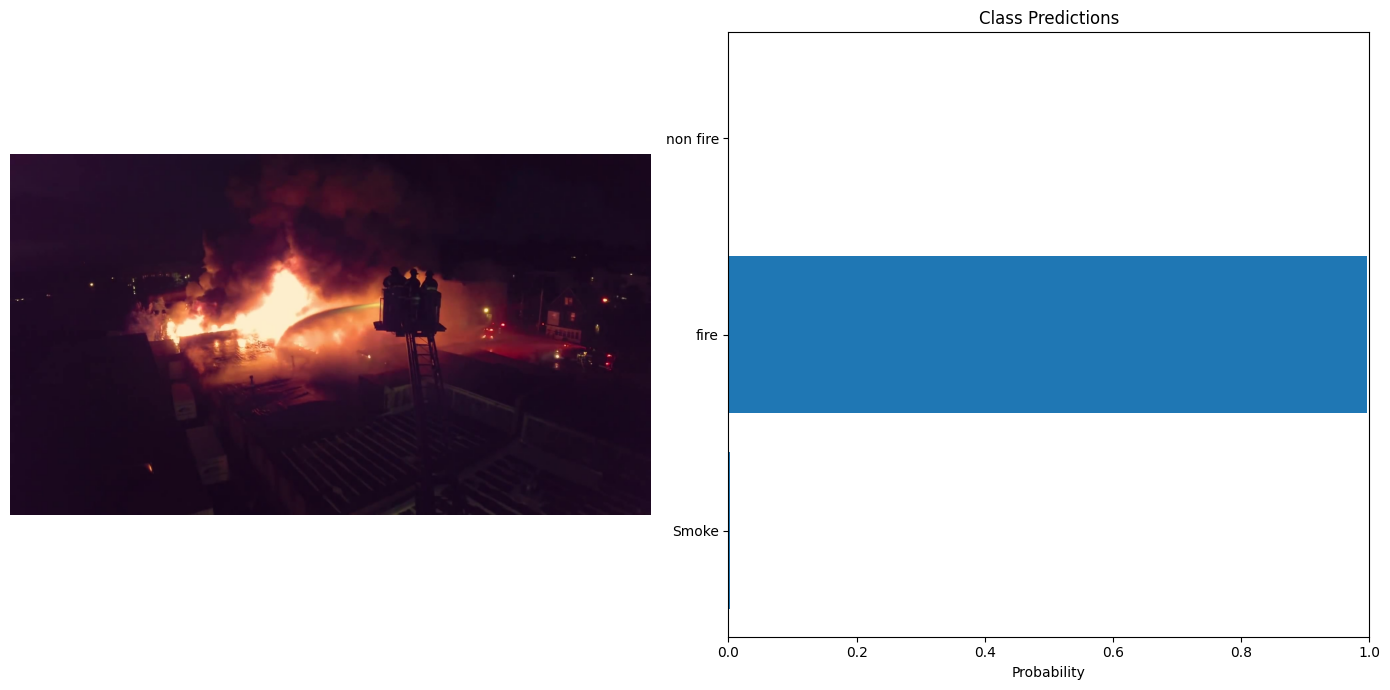

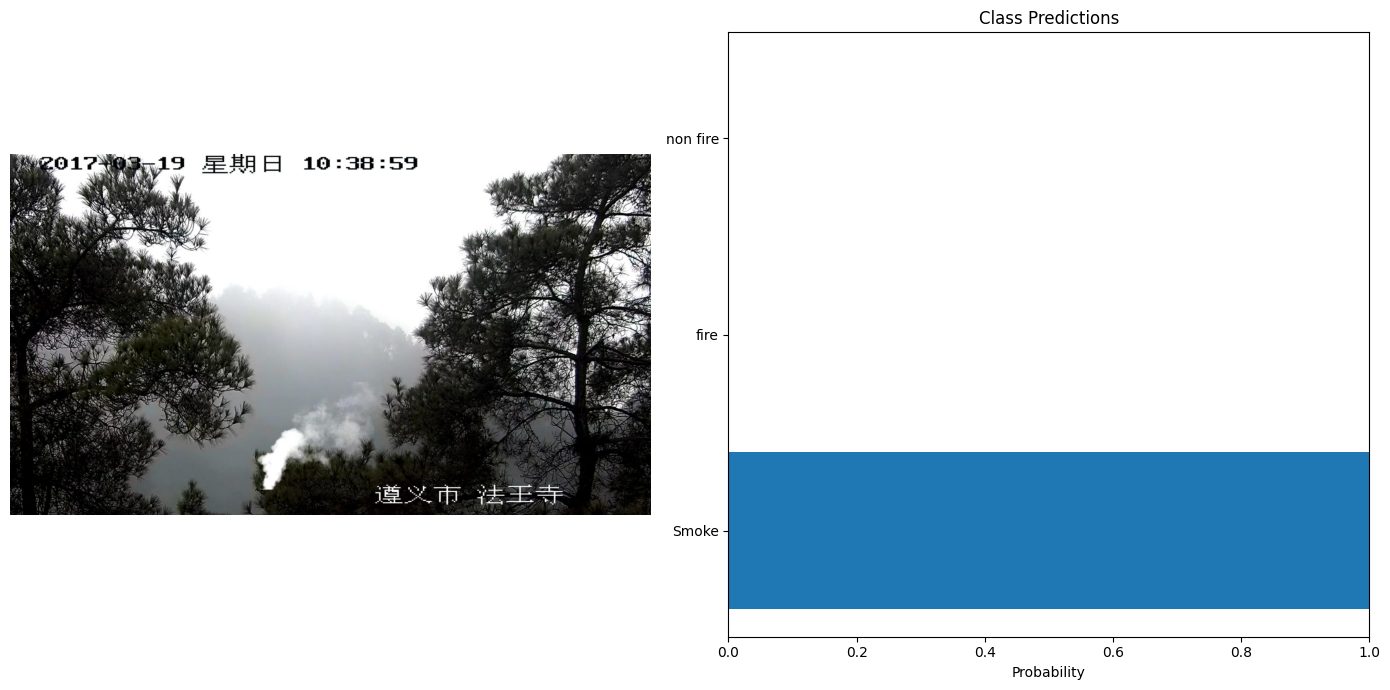

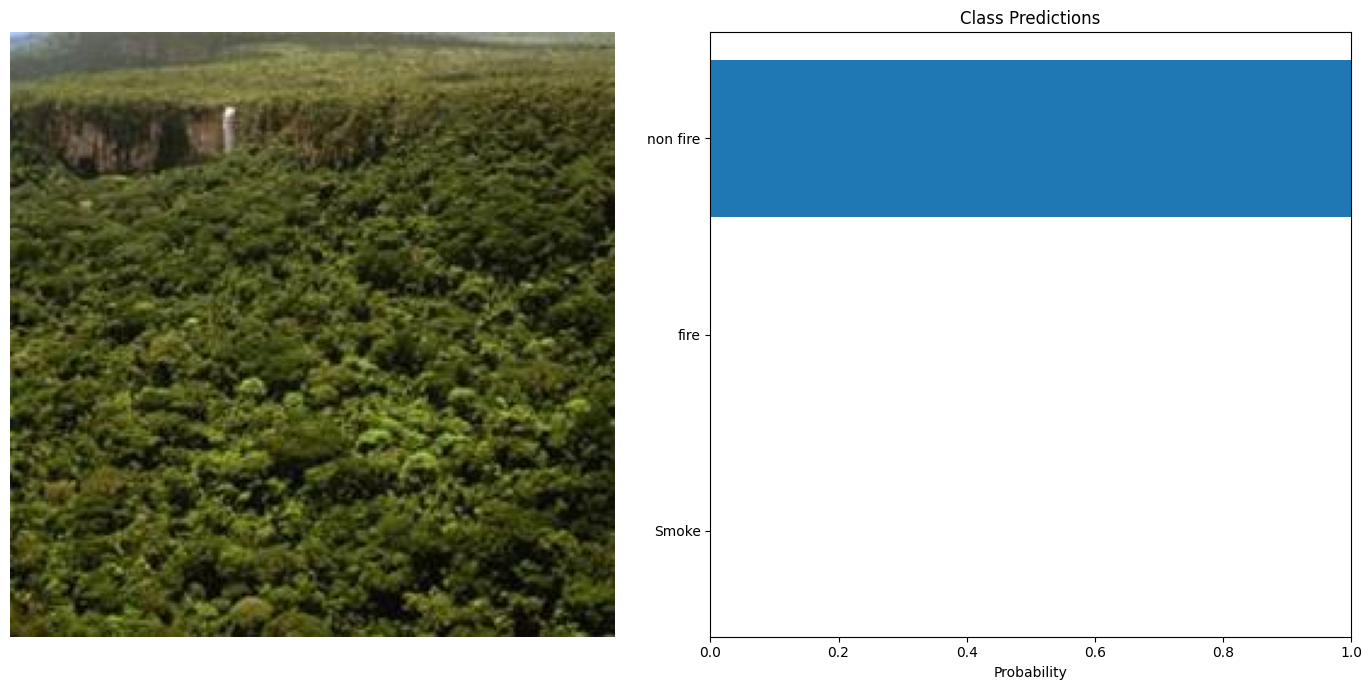

In [28]:
from glob import glob
test_images = glob('Datasets/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes 
    visualize_predictions(original_image, probabilities, class_names)

In [29]:
# Save only the model's learned parameters (weights)
torch.save(model.state_dict(), 'camera_detection.pt')